## Data Collection
Predicting total colony forming units (CFU) from particle counts, time of day, weather, percentage of outdoor particulates, or location.

Goal: Organize your data to streamline the next steps of your capstone.

■ Data loading
■ Data joining

In [1]:
#importing the tools
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import os
import glob

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt

In [2]:
#Data loading
data = pd.read_excel(r'data\filt_cfus.xlsx', sheet_name = [0,3,4])

dfIC = pd.read_excel('data\VADIC.xlsx', sheet_name = [1], parse_dates=True)
dfMC = pd.read_excel('data\VADMC.xlsx', sheet_name = [0], parse_dates=True)
dfBMT = pd.read_excel('data\VADIC.xlsx', sheet_name = [4], parse_dates=True)

# dfMC is both hospital's particle air sampling data.
# dfIC is Infection Control's particle air sampling data.
# dfAHA is both hopsital's ad hoc particle air sampling data.

# Cleaning and unifying CFU data

In [3]:
for key in data:
     print(key, data[key].head())

0                   Date           location  cfu
0  2018-11-30 00:00:00   Inside Room L108    1
1  2018-11-30 00:00:00     ED Parking lot   34
2  2010-11-30 00:00:00  unused agar strip    0
3  2018-11-29 00:00:00  unused agar strip    0
4  2018-11-29 00:00:00   Inside Room L108    0
3         Date           location  cfu
0 2018-11-27  UNUSED AGAR STRIP    0
1 2018-11-27             11L NS    2
2 2018-11-27            11L SEC    5
3 2018-11-27             10M NS    1
4 2018-11-27           9MICU NS    2
4         Date                           location  cfu
0 2018-09-14  B1-C6 Balcony   BMT/Hem Onc Spine    1
1 2018-09-14             B1-A6 Balcony by A6577    1
2 2018-09-14             B1-A5 Balcony by A5577    2
3 2018-09-14             B1-A4 Balcony by A4577    1
4 2018-09-14             B1-C4 Balcony by C4877    2


In [4]:
#seperating CFU data into the 3 sheets
adhoc = pd.DataFrame(data[0])
ml = pd.DataFrame(data[3])
mb = pd.DataFrame(data[4])

print("\n ml: \n", ml.dtypes, ml.shape, "\n ad hoc: \n",adhoc.dtypes,adhoc.shape,"\n mb: \n", mb.dtypes, mb.shape)


 ml: 
 Date        datetime64[ns]
location            object
cfu                  int64
dtype: object (1403, 3) 
 ad hoc: 
 Date        object
location    object
cfu          int64
dtype: object (2532, 3) 
 mb: 
 Date        datetime64[ns]
location            object
cfu                  int64
dtype: object (1219, 3)


In [5]:
#fixing date in ad hoc cfu data
adhoc['Date'] = pd.to_datetime(adhoc['Date'])
adhoc.dtypes

Date        datetime64[ns]
location            object
cfu                  int64
dtype: object

## Fixing location names

In [6]:
#removing the unused test samples
adhoc = adhoc[adhoc['location']!='UNUSED AGAR STRIP']
ml = ml[ml['location']!='UNUSED AGAR STRIP']
ml.location

1                      11L NS
2                     11L SEC
3                      10M NS
4                    9MICU NS
5                       9L NS
                ...          
1398                    7L NS
1399                   7L SEC
1400                   ED LOT
1401           L26 NS RAD/ONC
1402    L52 L53 OUTSIDE ROOMS
Name: location, Length: 1260, dtype: object

In [7]:
#all need to be updated
ml.location.unique(),mb.location.unique(),adhoc.location.unique()

(array(['11L NS', '11L SEC', '10M NS', '9MICU NS', '9L NS', '9L SEC',
        'ED LOT', 'L26 NS RAD/ONC', 'L52 L53 OUTSIDE ROOMS', '9Licu NS',
        'L53 RADONC', '14M NS', '9M SEC', '10M SEC', '7L NS', '11M NS',
        'M-service elevators', '7L BMT', '7L SEC', 'MZ 5N NS ',
        'MZ Shuttle Stop', '8M NS', '11M SEC', '14L NS'], dtype=object),
 array(['B1-C6 Balcony   BMT/Hem Onc Spine', 'B1-A6 Balcony by A6577',
        'B1-A5 Balcony by A5577', 'B1-A4 Balcony by A4577',
        'B1-C4 Balcony by C4877', 'B2-C4 Balcony by C4899A',
        'B2-C5 Balcony by C5877', 'B2-C6 Balcony by C6877',
        'B1-C5 Balcony Msurge/CTCU Spine',
        'BMT South Entrance Inside Double Doors BMT by C6901 (South)',
        'BMT Central Entrance Inside Double Doors BMT by C6913 (Central)',
        'BMT South Team Station by C6915 BMT by C6915 (South)',
        ' BMT in Unit by Emergency Stairwell BMT by C6924',
        'BMT Central Station by C6958 BMT by C6958',
        'BMT North Team by C69

In [8]:
#ML first up. Not too many corrections
ml_replace = {'L26 NS RAD/ONC':'L26','L53 RADONC':'L53','ED LOT':'ED Lot'}
ml['location'] = ml['location'].replace(ml_replace)

In [9]:
#a lot more here. easier now that I've also named the particulate locations 
mb_replace = {'B1-C6 Balcony   BMT/Hem Onc Spine':'B1-C6','B1-A6 Balcony by A6577':'B1-A6',
              'B1-A5 Balcony by A5577':'B1-A5','B1-A4 Balcony by A4577':'B1-A4',
              'B1-C4 Balcony by C4877':'B1-C4','B2-C4 Balcony by C4899A':'B2-C4',
              'B2-C5 Balcony by C5877':'B2-C5','B2-C6 Balcony by C6877':'B2-C6',
              'B1-C5 Balcony Msurge/CTCU Spine':'B1-C5',
              'BMT South Entrance Inside Double Doors BMT by C6901 (South)':'BMT-C6901',
              'BMT Central Entrance Inside Double Doors BMT by C6913 (Central)':'BMT-C6913',
       'BMT South Team Station by C6915 BMT by C6915 (South)':'BMT-C6915',
       ' BMT in Unit by Emergency Stairwell BMT by C6924':'BMT-C6924',
       'BMT Central Station by C6958 BMT by C6958':'BMT-C6958',
       'BMT North Team by C6971 BMT by C6971 (North)':'BMT-C6971',
       'BMT North Entrance Inside Double Doors BMT by C6976 (North)':'BMT-C6976',
       'BMT Central Entrance Outside Double Doors BMT by C6984 (Central)':'BMT-C6984',
       'BMT Emergency\nStairwell BMT C6S90':'BMT-C6S90',
       'BMT Stairwell\nRefuge BMT C6S91':'BMT-C6S91',
       'BMT Central Entrance in Between Double Doors BMT Central Entrance':'BMT-CEIBDD',
       'BMT North Entrance in Between Double Doors BMT North Entrance Between':'BMT-NEIBDD',
       'BMT North Entrance Outside Double Doors BMT North Entrance Outside':'BMT-NEODD',
       'BMT South Entrance Outside Double Doors BMT South Entrance Outside':'BMT-SEODD',
       'BMT South Entrance in Between Double Doors BMT South Entrance Between':'BMT-SEIBDD',
       'Hem Onc North Entrance Inside Double Doors Hem Onc by C6801 (North)':'HO-C6801',
       'Hem Onc Team Station by C6807A Hem Onc by C6807':'HO-C6807',
       'Hem Onc Team Station by C6808 Hem Onc by C6808':'HO-C6808',
       'Hem Onc Reception Desk by C6827 Hem Onc by C6827':'HO-C6827',
       'Hem Onc Team Station by C6835 Hem Onc by C6835':'HO-C6835',
       'Hem Onc Team Station by C6838 Hem Onc by C6838':'HO-C6838',
       'Hem Onc in Unit by Emergency Stairwell Hem Onc by C6847A':'HO-C6847A',
       'BMT South\nEntrance inside\ndouble doors Hem Onc by C6899 (South)':'BMT-C6899',
       'Hem Onc Emergency Stairwell Stairs Hem Onc C6S80':'HO-C6S80',
       'Hem Onc Stairwell Area of Refuge Hem Onc C6S81':'HO-C6S81',
       'OGT3-C5 Outside Door across fr. C5433':'OGT3-C5',
       'OGT4-C4 Outside Door by C4828':'OGT4-C4',
       'Corridor GT2-C5 Terrace Door across fr. C5411':'GT2-C5',
       'Corridor GT1-C5 Terrace Door across fr. C5433':'GT1-C5',
       'Corridor GT2-C3 Terrace Door by A3879':'GT2-C3',
       'Corridor GT1-C3 Terrace Door by C3899':'GT1-C3',
       'Unit Corridor GT1-C4 Terrace door by C4617':'GT1-C4',
       'Corridor GT2-C4 Terrace Door by C4625':'GT2-C4',
       'Corridor GT3-C4 Terrace Door by C4828':'GT3-C4',
       'Shuttle Stop CSS Shuttle Stop CSS':'MBH Shuttle Stop',
       'ROL1-GMB1 Rad Onc Waiting Area/Lobby':'BMT-ROL1-GMB1'}
mb['location'] = mb['location'].replace(mb_replace)
mb = mb[mb['location']!=' Unusded RB Agar Strip']
mb['location'].value_counts()

MBH Shuttle Stop    31
B1-A6               30
GT1-C4              30
OGT3-C5             30
B1-C5               30
OGT4-C4             29
B2-C6               29
B1-A4               29
B2-C5               29
B1-C4               29
GT2-C3              29
GT2-C5              29
BMT-C6901           28
B1-A5               28
GT2-C4              28
B1-C6               28
GT1-C3              28
B2-C4               28
GT3-C4              28
BMT-ROL1-GMB1       27
BMT-C6913           27
BMT-C6S91           27
GT1-C5              26
HO-C6801            26
HO-C6838            26
HO-C6835            26
HO-C6827            25
BMT-C6S90           25
BMT-NEODD           25
BMT-SEIBDD          25
BMT-NEIBDD          25
HO-C6S80            25
BMT-C6924           25
HO-C6807            25
BMT-CEIBDD          25
BMT-C6915           25
HO-C6808            25
BMT-C6971           25
BMT-SEODD           25
BMT-C6976           25
HO-C6S81            24
BMT-C6958           24
BMT-C6899           24
BMT-C6984  

In [10]:
set(adhoc.location.unique())

{nan,
 'ACC FIRST FLOOR WAITING ROOM OF PED TREATMENT CTR',
 'BMT Room 2 C6 Inside room',
 'OUTSIDE ROOM M41',
 '7 LONG BY SOUTH STAIRWELL',
 'MZ - X Ray Rm. J149 No Traffic',
 'Long or 11',
 'HEM ONC By C6835',
 'Pedi TX Ctr MZ - Clinic hallway outside pt. tx rooms in back,.',
 'ADULT PACU # 19',
 '9 icu Nurses station',
 'Hallway outside following room - L812',
 'P Long ICU Nursing station',
 'Hallway outside L166',
 '11L L04',
 'No. 3 L43 Tx area',
 'ACC Hallway Outside 531 A New construction',
 '8 SOUTH NS',
 '8S Nursing Station low traffic',
 '11 ICC/ICC',
 'End of south hallway by stair entrance with door open no traffic',
 'BMT by C6901 South Inside Ddoors No Traffic',
 'Rad Outside Restrooms M3t4 and M3t3',
 'MTZ HALLWAY OUTSIDE ROOM A242',
 'Hallway outside L166 - follow up',
 'Inside L1116',
 'M547 #2',
 'Inside Stairway on 4th Floor by C4S81 MBH',
 'Inside South Double Doors of 8L',
 'MZ Bld A 6th floor Hallway outside A633',
 'Balcony by C4877 Low Traffic',
 'BMT by C6913 (

In [11]:
#due to the nature of ad hoc sampling, locations will not be uniform. will just clean up entry errors.
#halfway through realized I could have lowered the case of everything first to make it easier
ah_replace = {'unused agar strip':'UNUSED AGAR STRIP','ED Parking lot':'ED Lot','UNUSED MEDIA':'UNUSED AGAR STRIP',
             'unused media':'UNUSED AGAR STRIP','Mt. Zion Suttle Stop':'MZ Shuttle Stop','ED Parking Lot by Planters':'ED Lot',
             'Blank Strip':'UNUSED AGAR STRIP','ED parking lot':'ED Lot','MZ - UNUSED RB AGAR Strip':'UNUSED AGAR STRIP',
             'MB Shuttle stop':'MBH Shuttle Stop','Unused RB Agar Strips':'UNUSED AGAR STRIP','Ed Parking Lot':'ED Lot',
             'Unused RB Agar strip':'UNUSED AGAR STRIP','ED Parking Lot low traffic near plants':'ED Lot',
             'ED LOR':'ED Lot','MBH Shuttle Stop  ':'MBH Shuttle Stop','ED parking lot (control)':'ED Lot',
             'Control ED Parking Lot':'ED Lot','UNUSED AGAR STRIP ':'UNUSED AGAR STRIP','Unused AGAR Strip':'UNUSED AGAR STRIP',
             'UNUSED STRIP':'UNUSED AGAR STRIP','Unused RB AGAR':'UNUSED AGAR STRIP','Unsused RB Agar Strip':'UNUSED AGAR STRIP',
              'Unused Agar Strip':'UNUSED AGAR STRIP','Unused RB Agar Strip':'UNUSED AGAR STRIP','Unused RG Agar Strip':'UNUSED AGAR STRIP',
             'ED Parking Lot Low traffic Near Plants':'ED Lot','MZ  Shuttle Stop':'MZ Shuttle Stop','Mt. Zion Shuttle stop':'MZ Shuttle Stop',
             'ED Parking Lot':'ED Lot','ED PARKING LOT':'ED Lot','Unused RB Strip':'UNUSED AGAR STRIP','Unused RB AGAR Strip':'UNUSED AGAR STRIP',
             'UNUSED RB STRIP':'UNUSED AGAR STRIP','ED Parking':'ED Lot'}
adhoc['location'] = adhoc['location'].replace(ah_replace)
adhoc = adhoc[adhoc['location']!='UNUSED AGAR STRIP']
adhoc['location'].value_counts()

ED Lot                                                         268
10 ICC                                                          14
MZ Shuttle stop                                                 14
MBH Shuttle Stop                                                12
M547                                                            11
                                                              ... 
MZ OUTSIDE HALLWAY BETWEEN H006 AND H002                         1
Outside Door Across FR C5433 No Traffic                          1
ACC 5TH FLR HALLWAY BETWEEN HEME ONC CLIN. & DIABETES CLIN.      1
Inside patient room L1262 no traffic                             1
ACC FIRST FLOOR WAITING ROOM OF PED TREATMENT CTR                1
Name: location, Length: 1649, dtype: int64

In [12]:
#adding a source
adhoc['Source'] = 'adhoc'
ml['Source'] = 'ML'
mb['Source'] = 'MB'

In [13]:
print("\n ml", ml.dtypes, "\n ad hoc",adhoc.dtypes,"\n mb", mb.dtypes)
adhoc['cfu'].unique()


 ml Date        datetime64[ns]
location            object
cfu                  int64
Source              object
dtype: object 
 ad hoc Date        datetime64[ns]
location            object
cfu                  int64
Source              object
dtype: object 
 mb Date        datetime64[ns]
location            object
cfu                  int64
Source              object
dtype: object


array([ 1, 34,  0,  9,  3,  2,  5, 27, 14,  4, 11, 24, 22,  7, 23, 19, 20,
        8, 13, 12, 28, 10, 17, 18, 30,  6, 16, 15, 31, 26, 25, 21, 86, 46,
       32, 29, 33, 39], dtype=int64)

## time to merge the CFU dfs

In [14]:
cfu_df = pd.DataFrame(pd.concat([adhoc, ml, mb]))
cfu_df = cfu_df.dropna()
cfu_df.sample(12), cfu_df.shape

(           Date                                           location  cfu Source
 1928 2007-09-18                                       unused strip    0  adhoc
 2098 2006-12-05                 11 NICU HALLWAY OUTSIDE OF 11 & 12    0  adhoc
 230  2018-01-02                             Hallway outside 14 14M    0  adhoc
 103  2017-12-13                                             9L SEC    3     ML
 385  2017-03-21                                          BMT-C6971    0     MB
 2466 2004-04-26                                      10ICC Room 12    0  adhoc
 405  2017-03-21                                      BMT-ROL1-GMB1    4     MB
 546  2016-10-03  Public Corridor outside door leading into cont...    0  adhoc
 916  2016-06-10                                     OR12 Parnassus    0  adhoc
 1156 2016-03-16  C6 To the right side of the door for Room: \nB...    0  adhoc
 2013 2007-06-08                                               L731   12  adhoc
 1263 2015-09-17     L72 outside of hard

In [15]:
cfu_df.describe()
cfu_df.info()
len(cfu_df.location.unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4781 entries, 0 to 1218
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4781 non-null   datetime64[ns]
 1   location  4781 non-null   object        
 2   cfu       4781 non-null   int64         
 3   Source    4781 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 186.8+ KB


1713

In [16]:
cfu_locs = list(cfu_df.location.drop_duplicates())

In [17]:
print(len(cfu_locs),len(cfu_df.location))

1713 4781


## Time for the Air particulate data cleaning

In [18]:
#too many missing notes
ic = pd.DataFrame(dfIC[1])
mc = pd.DataFrame(dfMC[0])
bmt = pd.DataFrame(dfBMT[4])

ic = ic.drop('Notes', axis=1)
mc = mc.drop('Notes', axis=1)

In [19]:
print("\n ic: \n", ic.dtypes, ic.shape, "\n mc: \n",mc.dtypes,mc.shape, "\n bmt: \n",bmt.dtypes,mc.shape)


 ic: 
 Sampling Date            datetime64[ns]
Sample Location                  object
Temp                             object
RH                              float64
Particle (total >.3)            float64
Particle (>.5 per m3)           float64
Time of Sampling                float64
Traffic                          object
SF Gate Weather                  object
dtype: object (334, 9) 
 mc: 
 Sampling Date            datetime64[ns]
Sample Location                  object
Temp                            float64
RH                              float64
Particle (total >.3)            float64
Particle (>.5 per m3)           float64
Time of Sampling                 object
Traffic                         float64
SF Gate Weather                  object
dtype: object (2406, 9) 
 bmt: 
 Sampling Date            datetime64[ns]
Sample Location                  object
Temp                            float64
RH                                int64
Particle (>.5 per m3)             int64
SF Gate 

In [20]:
#Renaming and unifying column names
ic = ic.rename(columns={"Sampling Date":"Date",
                            "Sample Location":"location",
                            "Particle (total >.3)":"Total_Particles>0.3",
                            "Particle (>.5 per m3)":"Total_Particles>0.5/m3",
                            "Time of Sampling":"Sample_Time",
                            "SF Gate Weather":"Weather",
                            "Percentage .3 over .5":"Ratio_0.3/0.5"})
mc = mc.rename(columns={"Sampling Date":"Date",
                            "Sample Location":"location",
                            "Particle (total >.3)":"Total_Particles>0.3",
                            "Particle (>.5 per m3)":"Total_Particles>0.5/m3",
                            "Time of Sampling":"Sample_Time",
                            "SF Gate Weather":"Weather",
                            "Percentage .3 over .5":"Ratio_0.3/0.5"})
bmt = bmt.rename(columns={"Sampling Date":"Date",
                            "Sample Location":"location",
                            "Particle (total >.3)":"Total_Particles>0.3",
                            "Particle (>.5 per m3)":"Total_Particles>0.5/m3",
                            "Time of Sampling":"Sample_Time",
                            "SF Gate Weather":"Weather",
                            "Percentage .3 over .5":"Ratio_0.3/0.5"})

print(mc.keys(),ic.keys(),bmt.keys())

Index(['Date', 'location', 'Temp', 'RH', 'Total_Particles>0.3',
       'Total_Particles>0.5/m3', 'Sample_Time', 'Traffic', 'Weather'],
      dtype='object') Index(['Date', 'location', 'Temp', 'RH', 'Total_Particles>0.3',
       'Total_Particles>0.5/m3', 'Sample_Time', 'Traffic', 'Weather'],
      dtype='object') Index(['Date', 'location', 'Temp', 'RH', 'Total_Particles>0.5/m3', 'Weather'], dtype='object')


In [21]:
#fixing traffic type
mc['Traffic'] = mc['Traffic'].astype('object')
assert mc['Traffic'].dtype == 'object'

ic['Traffic'] = ic['Traffic'].astype('category')
assert ic['Traffic'].dtype == 'category'

In [22]:
#fixing traffic column
replace = {1:'Low',2:'Medium',3:'High',0:'None','No data "occupied space"':'None',
           'No data':'None','high staff data':'High'}
ic['Traffic'] = ic['Traffic'].replace(replace)
mc['Traffic'] = mc['Traffic'].replace(replace)

In [23]:
mc['Traffic'].value_counts(),ic['Traffic'].value_counts()

(Low       1037
 None       588
 High       453
 Medium     323
 Name: Traffic, dtype: int64,
 Low       169
 None       92
 Medium     42
 High       19
 Name: Traffic, dtype: int64)

# taking a look at temperature

In [24]:
mc.Temp.describe()

count    1839.000000
mean       75.406444
std       166.345022
min        35.800000
25%        70.800000
50%        72.200000
75%        73.500000
max      7203.000000
Name: Temp, dtype: float64

In [25]:
mc = mc[mc.Temp < 100]
mc.Temp.describe()

count    1838.000000
mean       71.528536
std         3.935694
min        35.800000
25%        70.800000
50%        72.200000
75%        73.500000
max        95.700000
Name: Temp, dtype: float64

In [26]:
ic.Temp.unique()

array([72.9, 68, 71, 72.8, 68.7, 66.1, 72, 71.7, 71.8, 66.9, 730, 72.4,
       74.61, 73.5, 74.3, 73.9, 66.7, 73.3, 65.6, 64.4, 70.5, 70.7, 70.8,
       73.4, 71.6, 71.9, 71.5, 75.7, 75, 75.2, 75.3, 75.5, 73.1, 69.6,
       71.3, 68.2, 67.2, 60, 66.8, 73, 71.4, 69, 74.7, 73.7, 63.2, 73.6,
       70.4, 63.1, 68.9, 70, 60.4, 74.2, 62.7, 67.1, 70.51, 58.4, 65.3,
       69.2, 59.3, 635, 59.31, 67.4, 60.1, 64.5, 72.1, 72.6, 65.5, 77.3,
       76, 68.5, 63.8, 72.3, 63.3, 67, 57.6, 69.5, 62.1, 61.1, 63, 60.9,
       63.5, 67.3, 62.8, 55, 69.4, 61.3, 67.8, 67.9, 61.9, nan, 75.9,
       65.7, 74.1, 70.9, 66, '6 (?)', 68.3, 58.8, 71.1, 74, 70.2, 60.2,
       69.9, 54.7, 62.71, 60.6, 65.4, 65.8, 66.6, 54.1, 66.5, 64.2, 60.3,
       63.4, 69.7, 62.3, 69.8, 70.1, 50.3, 56.7, 69.3, 68.4, 69.1, 70.3,
       71.2, 57.7, 72.2, 56.4, 61.8, 58.7, 73.8, 72.7, 70.6, 59.7, 74.6,
       74.8, 57, 74.5, 75.8, 76.3, 72.5, 68.1, 50.2, 55.8, 59.8, 60.8,
       58.3], dtype=object)

In [27]:
ic.Temp = ic.Temp.astype('str')
ic = ic[ic['Temp'] != '6 (?)']
ic.Temp = ic.Temp.astype('float')
ic.sample(12)

,Date,location,Temp,RH,Total_Particles>0.3,Total_Particles>0.5/m3,Sample_Time,Traffic,Weather
238,2017-03-29,10 ICC Hallway Outside Bed 8,71.3,48.0,2652.0,147880.0,1300.0,Medium,Partly Cloudy
42,2019-03-19,ED Parking Lot,69.6,36.0,212713.0,3498940.0,1221.0,Medium,Cloudy
187,2018-01-03,Hallway outside 1414M,70.1,42.0,129554.0,2183746.0,1116.0,Low,Mostly Cloudy
105,2018-06-19,ED Parking Lot,57.6,62.0,115764.0,4622968.0,1040.0,Low,Cloudy
324,2012-07-09,Hallway outside L75,71.4,50.6,54644.0,NaN,1530.0,Low,NaN
299,2017-10-12,"Public corridor, Long hallway (north Hallway o...",69.4,32.0,406032.0,4946996.0,730.0,High,Haze
166,2018-01-23,Substerile 8/9 (near OR 9 entry point),65.8,52.0,1010.0,45760.0,643.0,None,Cloudy
330,2012-07-11,Hallway outside L75,71.4,48.8,45745.0,NaN,1000.0,Low,NaN
289,2017-12-19,ED Parking Lot,56.4,46.0,602534.0,13514310.0,833.0,Low,Mostly Cloudy
176,2018-01-12,10ICC Hallway outside rm 9,68.5,59.0,1776.0,97703.0,1251.0,Low,Overcast


In [28]:
ic = ic[ic['Temp'] < 100]
ic.Temp.describe()

count    329.000000
mean      68.449666
std        5.135799
min       50.200000
25%       66.000000
50%       70.000000
75%       71.900000
max       77.300000
Name: Temp, dtype: float64

In [29]:
#removing NAs from both MC and IC data
ic = ic[ic['Total_Particles>0.3'].notna()]
ic = ic[ic['Total_Particles>0.5/m3'].notna()]
mc = mc[mc['Total_Particles>0.3'].notna()]
mc = mc[mc['Total_Particles>0.5/m3'].notna()]

In [30]:
mc['Weather'] = mc['Weather'].astype('category')
assert mc['Weather'].dtype == 'category'

ic['Weather'] = ic['Weather'].astype('category')
assert ic['Weather'].dtype == 'category'

In [31]:
print("\n ic: \n", ic.dtypes, "\n mc: \n",mc.dtypes)


 ic: 
 Date                      datetime64[ns]
location                          object
Temp                             float64
RH                               float64
Total_Particles>0.3              float64
Total_Particles>0.5/m3           float64
Sample_Time                      float64
Traffic                           object
Weather                         category
dtype: object 
 mc: 
 Date                      datetime64[ns]
location                          object
Temp                             float64
RH                               float64
Total_Particles>0.3              float64
Total_Particles>0.5/m3           float64
Sample_Time                       object
Traffic                           object
Weather                         category
dtype: object


In [32]:
#fixing time
#pd.to_datetime(mc["Sample_Time"],format='%H%M').dt.time
#ic['Sample_Time'] = pd.to_datetime(ic["Sample_Time"]).dt.strftime('%H:%M')
ic = ic.drop('Sample_Time', axis=1)
mc = mc.drop('Sample_Time', axis=1)

## fixing location names in the particulate DFs

In [33]:
mc.location.unique()

array(['Long 26', 'Long 53', '11 Long Nursing Station',
       '11 Long Service Elevator', '9 Long Nurses Station',
       '9 Long Service Elevator', '9 Long ICU Nurses Station',
       '10 ICC Nurses Station', 'ED Parking Lot', 'Balcony by A6577',
       'Balcony by A5577', 'Balcony by A4577',
       'Terrace Door across fr. C5433', 'Terrace Door across fr. C5411',
       'Outside Door across fr. C5433', 'Terrace Door by C4617',
       'Terrace Door by C4625', 'Terrace Door by C4828',
       'Outside Door by C4828', 'Balcony BMT/Hem Onc Spine',
       'Balcony by C6877', 'Balcony Msurge/CTCU Spine',
       'Balcony by C5877', 'Balcony by C4877', 'Balcony by C4899A',
       'Terrace Door by C3899', 'Terrace Door by A3879',
       'Rad Onc Waiting Area/Lobby', 'Hem Onc by C6801 (North)',
       'Hem Onc by C6899 (South)', 'Hem Onc by C6847A', 'Hem Onc C6S81',
       'Hem Onc C6S80', 'Hem Onc by C6827', 'Hem Onc by C6807',
       'Hem Onc by C6808', 'Hem Onc by C6835', 'Hem Onc by C6838'

In [34]:
mc_replace = {'Long 26':'L26','Long 53':'L53',
              '11 Long Nursing Station':'11L NS','11 Long Service Elevator':'11L SEC',
              '9 Long Nurses Station':'9L NS','9 Long Service Elevator':'9L SEC',
              '9 Long ICU Nurses Station':'9Licu NS','9 Moffitt ICU Nurses Station':'9MICU NS',
              '10 ICC Nurses Station':'10ICC NS','Balcony by A6577':'B1-A6','Balcony by A5577':'B1-A5',
              'Balcony by A4577':'B1-A4','Balcony BMT/Hem Onc Spine':'B1-C6','Balcony by C6877':'B1-C6',
              'Balcony Msurge/CTCU Spine':'B1-C5','Balcony by C5877':'B1-C5','Balcony by C4877':'B1-C4',
              'Balcony by C4899A':'B2-C4','Balcony B1-A5 by A5577':'B1-A5','Balcony B1-A4 by A4577':'B1-A4',
              'Balcony B1-A6 by A6577':'B1-A6',
              'Balcony B1-C6 Between BMT/Hem Onc Spine':'B1-C6','Balcony B2-C6 by C6877':'B2-C6',
              "Balcony B2-C5 Between Children's Msurge/CTCU Spine":'B1-C5','Balcony B2-C5 by C5877':'B2-C5',
              'Balcony B1-C4 by C4877':'B1-C4','Balcony B2-C4 in C4899A Anteroom':'B2-C4',
              'Terrace Door across fr. C5433':'GT1-C5','Terrace Door across from C5433':'GT1-C5',
              'Terrace Door across fr. C5411':'GT2-C5','Terrace Door across from C5411':'GT2-C5',
              'Outside Door across fr. C5433':'OGT3-C5','Terrace Door by C4617':'GT1-C4',
              'Terrace Door by C4625':'GT2-C4','Terrace Door by C4828':'GT3-C4',
              'Outside Door by C4828':'OGT4-C4','Terrace Door by C3899':'GT1-C3',
              'Terrace Door by A3879':'GT2-C3','Terrace Door across from C5433':'GT1-C5',
              'Rad Onc Waiting Area/Lobby':'ROL1-GMB1','Hem Onc by C6801 (North)':'HO-C6801',
              'Hem Onc by C6899 (South)':'HO-C6899','Hem Onc by C6847A':'HO-C6847A', 'Hem Onc C6S81':'HO-C6S81',
              'Hem Onc C6S80':'HO-C6S80', 'Hem Onc by C6827':'HO-C6827', 'Hem Onc by C6807':'HO-C6807',
              'Hem Onc by C6808':'HO-C6808', 'Hem Onc by C6835':'HO-C6835', 'Hem Onc by C6838':'HO-C6838',
              'BMT by C6971 (North)':'BMT-C6971N', 'BMT by C6958 (Central)':'BMT-C6958C',
              'BMT by C6971 (South)':'BMT-C6971S', 'BMT North Entrance':'BMT-C6NE',
              'BMT by C6976 (North)':'BMT-C6976N', 'BMT by C6984 (Central)':'BMT-C6984C',
              'BMT Central Entrance':'BMT-C6CE', 'BMT by C6913 (Central)':'BMT-C6913C',
              'BMT South Entrance':'BMT-C6SE', 'BMT By C6901 (South)':'BMT-C6901S', 'BMT by C6924':'BMT-C6924',
              'BMT C6S91':'BMT-C6S91', 'BMT C6S90':'BMT-C6S90','BMT by C6958 ':'BMT-C6958', 'BMT by C6971 ':'BMT-C6971',
              'Hem Onc by C6S81':'HO-C6S81', 'Hem Onc by C6S80':'HO-C6S80','Outside Door across from C5433':'OGT3-C5',
              '9 Long Service Station':'9L SS','Outside Door by  C4828':'OGT4-C4', 'BMT by C6915 (South)':'BMT-C6915S',
              'Hem Onc by C6801(South)':'HO-C6801S', 'BMT by C6913 (North)':'BMT-C6913N','BMT by C6901 (South)':'BMT-C6901',
              'Garden Terrace Door Corridor GT1-C4 across fr. C5433':'GT1-C4',
              'Garden Terrace Door Corridor GT2-C5 across fr. C5411':'GT2-C5',
              'Outside Doors OGT3-C5 across fr. C5433 outside double doors ':'OGT3-C5',
              'Garden Terrace Door Unit Corridor GT1-C4 by C4617':'GT1-C4',
              'Garden Terrace Door Corridor GT2-C4 by C4625':'GT2-C4',
              'Garden Terrace Door Corridor GT3-C4 by C4828':'GT3-C4',
              'Outside Doors OGT4-C4 by C4828':'OGT4-C4','Garden Terrace Corridor GT1-C3 by C3899':'GT1-C3',
              'Garden Terrace Corridor GT2-C3 by A3879':'GT2-C3','Rad Onc Waiting Area/Lobby ':'ROL1-GMB1',
              'Hem Onc by C6801 Inside double doors (North Entrance)':'HO-C6801N',
              'Hem Onc by C6899 Inside double doors (South Entrance)':'HO-C6899S',
              'Hem Onc In unit by emergency stairwell by C6847A':'HO-C6847A',
              'Hem Onc Emergency stairwell area of refuge C6S81':'HO-C6S81',
              'Hem Onc Emergency Stairwell C6S80':'HO-C6S80','Hem Onc Reception desk by C6827':'HO-C6827',
              'Hem Onc Team Station by C6807A':'HO-C6807A', 'Hem Onc Team Station by C6808':'HO-C6808',
              'Hem Onc Team Station by C6835':'HO-C6835', 'Hem Onc Team Station by C6838':'HO-C6838',
              'BMT North Team Station by C6971 ':'BMT-C6971','BMT Central Team Station By C6958':'BMT-C6958',
              'BMT South Team Station by C6915 ':'BMT-C6915',
              'BMT North Entrance Outside double doors':'BMT-NEODD','BMT North Entrance In between double doors ':'BMT-NEIBDD',
       'BMT North Entrance Inside double doors by C6976 ':'BMT-C6976',
       'BMT Central Entrance Outside double doors by C6984 ':'BMT-C6984',
       'BMT Central Entrance In between double doors ':'BMT-CEIBDD',
       'BMT Central Entrance Inside double doors by C6913':'BMT-C6913',
       'BMT South Entrance Outside double doors':'BMT-SEODD',
       'BMT South Entrance In between double doors ':'BMT-CEIBDD',
       'BMT South Entrance Inside double doors By C6901':'BMT-C6901',
       'BMT In Unit by Emergency stairwell by C6924':'BMT-C6924',
       'BMT Emergency stairwell Area of Refuge by C6S91':'BMT-C6S91',
       'BMT Emergency stairwell by C6S90':'BMT-C6S90',
              'ED Parking Lot':'ED Lot'}
mc['location'] = mc['location'].replace(mc_replace)

In [35]:
mc.location.unique()

array(['L26', 'L53', '11L NS', '11L SEC', '9L NS', '9L SEC', '9Licu NS',
       '10ICC NS', 'ED Lot', 'B1-A6', 'B1-A5', 'B1-A4', 'GT1-C5',
       'GT2-C5', 'OGT3-C5', 'GT1-C4', 'GT2-C4', 'GT3-C4', 'OGT4-C4',
       'B1-C6', 'B1-C5', 'B1-C4', 'B2-C4', 'GT1-C3', 'GT2-C3',
       'ROL1-GMB1', 'HO-C6801', 'HO-C6899', 'HO-C6847A', 'HO-C6S81',
       'HO-C6S80', 'HO-C6827', 'HO-C6807', 'HO-C6808', 'HO-C6835',
       'HO-C6838', 'BMT-C6971N', 'BMT-C6958C', 'BMT-C6971S', 'BMT-C6NE',
       'BMT-C6976N', 'BMT-C6984C', 'BMT-C6CE', 'BMT-C6913C', 'BMT-C6SE',
       'BMT-C6901S', 'BMT-C6924', 'BMT-C6S91', 'BMT-C6S90',
       'MBH Shuttle Stop', '9MICU NS', 'BMT-C6958', 'BMT-C6971', '9L SS',
       'BMT-C6915S', 'HO-C6801S', 'BMT-C6913N', 'BMT-C6901', 'B2-C6',
       'B2-C5', 'HO-C6801N', 'HO-C6899S', 'HO-C6807A', 'BMT-C6915',
       'BMT-NEODD', 'BMT-NEIBDD', 'BMT-C6976', 'BMT-C6984', 'BMT-CEIBDD',
       'BMT-C6913', 'BMT-SEODD'], dtype=object)

In [36]:
ic.location.unique()

array(['Hallway by Nursing Station outside plastic Barrier 14M',
       'Outside of double-doors in long corridor labeled with sign "Staff Only Do Not Enter." These doors are immediately adjacent to 15L north hallways and 15L waiting room. ',
       'Immediately outside of construction barricade, inside area labedled "Staff Only Do Not Enter".',
       'Outside 15M west stairwell (barricaded, emergency exit only from construction area).',
       'Outside 15M east stairwell (barricaded, emergency exit only from construction area).',
       'ED Parking Lot',
       'Inside 6 Moffitt South (M618) ICC nursing station',
       'Inside 6 Moffitt South ICC Bed 1',
       'Inside 6 Moffitt South ICC Bed 10',
       'Inside 6 Moffitt Sout ICC Bed 9', 'Outside Construction barrier',
       'Outside double doors to 12N (cath lab)', 'Inside unit 12N',
       'Hallway 12S Corridor', 'Room J146 Mammography Waiting Room',
       'MZ Shuttle Stop', 'Right side hall next to reception desk 8NICU',
     

In [37]:
#due to the nature of ad hoc sampling, locations will not be uniform. will just clean up entry errors.
#halfway through realized I could have lowered the case of everything first to make it easier
ic_replace = {'ED Parking Lot':'ED lot','Mammorgraphy waiting room J146':'Mammography waiting room J146'}
ic['location'] = adhoc['location'].replace(ic_replace)

In [38]:
#merging the particulate data now that they are in the same format
part_df = pd.DataFrame(pd.concat([ic, mc, bmt]))

part_df.sample(12), part_df.shape

(           Date          location  Temp    RH  Total_Particles>0.3  \
 788  2016-11-21        BMT-C6984C  70.3  49.4                501.0   
 484  2017-05-17          9MICU NS  74.7  46.0             139775.0   
 87   2018-07-31          9Licu NS  72.1  53.0              34572.0   
 1549 2015-08-31        BMT-C6976N  72.4  50.1               1196.0   
 53   2018-07-24            Hood 4  71.5  52.0                  NaN   
 11   2019-01-25            Hood 4  74.0  36.0                  NaN   
 250  2017-12-22             B2-C4  70.1  29.0              23297.0   
 1523 2015-08-31            GT3-C4  71.9  53.7              45398.0   
 126  2018-05-07            ED Lot  69.4  49.0               5613.0   
 1244 2016-02-26             B1-A4  71.9  47.4              14403.0   
 903  2016-09-20  MBH Shuttle Stop  63.1  73.8             632500.0   
 1207 2016-03-22  MBH Shuttle Stop  57.9  50.0              79465.0   
 
       Total_Particles>0.5/m3 Traffic           Weather  
 788             

## working on the location name inconsistencies

In [39]:
print(set(cfu_df['location'].unique())-set(part_df['location'].unique()))

{'ACC FIRST FLOOR WAITING ROOM OF PED TREATMENT CTR', '6PICU Bed 5', 'OUTSIDE MOFFITT ER ENTRANCE', 'BMT Room 2 C6 Inside room', 'OUTSIDE ROOM M41', '7 LONG BY SOUTH STAIRWELL', 'Room B0-06 on 4/11/13', 'MZ - X Ray Rm. J149 No Traffic', 'Long or 11', 'Hallway outside 10 ICC bed 10', '9L Service elevator', 'Inside the Other South Double Door of 8L', 'BMT C6S90 Emer Stairway MBH', '11 LONG L1132', 'HEM ONC By C6835', 'Pedi TX Ctr MZ - Clinic hallway outside pt. tx rooms in back,.', 'ADULT PACU # 19', 'NS 8 ICU', 'Mt. Zion OR 2', '9 Long Nursing Station Parnassus', 'ACC FIRST FLOOR ED LOT CONTROL', '9 icu Nurses station', 'Hallway outside following room - L812', 'Inside patient room L1268 no traffic', 'M641 AC ON', 'MOFFITT OR # 14', 'P Long ICU Nursing station', 'Hallway outside L166', 'unused Agar strip', '11L L04', 'Balcony By C5877', 'No. 3 L43 Tx area', 'Public Corridor outside hard barrier vestibule door leading into contruction are high traffic', 'HALLWAY ADJACENT TO ELEV 3 BLDG A 

In [40]:
cfu_locations_df = pd.DataFrame(cfu_df, columns=['Date','location'])
part_locations_df = pd.DataFrame(part_df, columns=['Date','location'])
cfu_locations_df.head(), part_locations_df.head()

(        Date          location
 0 2018-11-30  Inside Room L108
 1 2018-11-30            ED Lot
 4 2018-11-29  Inside Room L108
 5 2018-11-29            ED Lot
 7 2018-11-20            ED Lot,
         Date          location
 0 2018-01-03  Inside Room L108
 1 2019-04-03            ED Lot
 2 2019-04-03               NaN
 3 2019-04-03               NaN
 4 2019-04-03  Inside Room L108)

# Time for merging

In [41]:
#fixing the index
cfu_df.shape, part_df.shape

((4781, 4), (2192, 8))

In [42]:
df = part_df.merge(cfu_df,  how='left', on=['Date','location'])
df.sample(12)

,Date,location,Temp,RH,Total_Particles>0.3,Total_Particles>0.5/m3,Traffic,Weather,cfu,Source
802,2017-05-17,9MICU NS,74.7,46.0,139775.0,6694523.0,Low,Clear,NaN,NaN
287,2017-12-18,NaN,72.1,26.0,71303.0,1425972.0,Low,Partly Cloudy,NaN,NaN
650,2017-09-30,HO-C6808,74.3,49.0,1083.0,72261.0,Low,Mostly Cloudy,NaN,NaN
119,2018-05-14,ED Lot,67.3,56.0,24110.0,649647.0,Low,Cloudy,7.0,adhoc
624,2017-09-30,B1-A6,74.3,48.0,6702.0,234099.0,Low,Mostly Cloudy,NaN,NaN
85,2018-07-18,NaN,72.1,59.0,7595936.0,643110.0,None,No data recorded,NaN,NaN
1392,2016-05-25,B1-A6,71.9,48.3,2421.0,125894.0,Low,Scattered Clouds,NaN,NaN
1526,2016-03-21,L53,70.2,57.0,34077.0,650883.0,Low,Overcast,NaN,NaN
1029,2016-12-21,GT2-C3,72.3,37.3,43376.0,638160.0,Low,Mostly Cloudy,1.0,MB
2190,2018-03-22,M697,66.4,54.0,NaN,9660.0,NaN,Rainy,NaN,NaN


In [43]:
#Testing without missing data
#dropping erroneous relative humidity values
#dropping duplicates
df1 = df.dropna(subset=['cfu','Total_Particles>0.3','Total_Particles>0.5/m3'])
df1 = df1.drop_duplicates(subset=["location",'Date'])
df1 = df1[df1.RH < 80]
df1.describe()

,Temp,RH,Total_Particles>0.3,Total_Particles>0.5/m3,cfu
count,859.000000,859.000000,8.590000e+02,8.590000e+02,859.000000
mean,71.546147,45.720140,4.787122e+04,1.347053e+06,5.289872
std,3.747397,9.758805,1.167403e+05,3.067172e+06,9.863688
min,38.900000,6.200000,7.640900e+01,4.950000e+02,0.000000
25%,70.400000,40.000000,2.865500e+03,1.585965e+05,0.000000
50%,72.100000,47.000000,1.422700e+04,4.254420e+05,1.000000
75%,73.700000,51.350000,4.640850e+04,1.164064e+06,4.000000
max,82.100000,79.000000,1.454263e+06,4.504894e+07,34.000000


In [44]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 49 to 2107
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    859 non-null    datetime64[ns]
 1   location                859 non-null    object        
 2   Temp                    859 non-null    float64       
 3   RH                      859 non-null    float64       
 4   Total_Particles>0.3     859 non-null    float64       
 5   Total_Particles>0.5/m3  859 non-null    float64       
 6   Traffic                 857 non-null    object        
 7   Weather                 716 non-null    object        
 8   cfu                     859 non-null    float64       
 9   Source                  859 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 73.8+ KB


In [45]:
df1['Weather'] = df1['Weather'].astype('category')
df1['Traffic'] = df1['Traffic'].astype('category')
assert df1['Weather'].dtype == 'category'

array([[<AxesSubplot:title={'center':'Temp'}>,
        <AxesSubplot:title={'center':'RH'}>],
       [<AxesSubplot:title={'center':'Total_Particles>0.3'}>,
        <AxesSubplot:title={'center':'Total_Particles>0.5/m3'}>],
       [<AxesSubplot:title={'center':'cfu'}>, <AxesSubplot:>]],
      dtype=object)

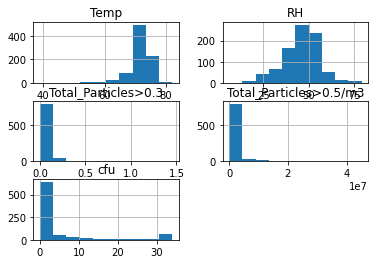

In [46]:
df1.hist(bins=10)

In [47]:
print("Rows:", df1.shape[0], "\nColumns:",df1.shape[1])

Rows: 859 
Columns: 10


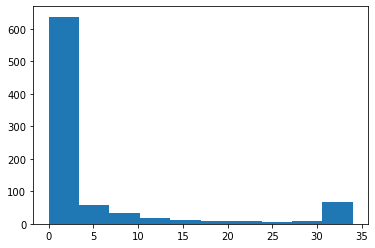

count    859.000000
mean       5.289872
std        9.863688
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       34.000000
Name: cfu, dtype: float64

In [48]:
#looking at data
plt.hist(df1['cfu'])
plt.show()
df1.cfu.describe()

In [49]:
df1["location"].value_counts(dropna=False)

ED Lot                           62
9L NS                            32
L26                              32
9L SEC                           29
11L NS                           25
                                 ..
Public Corridor outside HB047     1
B2-C6                             1
BMT-C6915                         1
B2-C5                             1
BMT-C6984                         1
Name: location, Length: 74, dtype: int64

Many locations are named in differing patterns, or the room number is in the prior sample(s).

In [50]:
unique_cfus = df1.drop_duplicates(subset=["location",'Date'])

df1.shape, unique_cfus.shape

((859, 10), (859, 10))

## Data Organization

File structure on github.

In [51]:
df1.dtypes

Date                      datetime64[ns]
location                          object
Temp                             float64
RH                               float64
Total_Particles>0.3              float64
Total_Particles>0.5/m3           float64
Traffic                         category
Weather                         category
cfu                              float64
Source                            object
dtype: object

In [52]:
df1.to_csv('data\combined_VAS.csv')

## Data Definition

Columns are temperature(Temp), relative humidity(RH), total amount of particulates larger than 0.3 microns(Total_Particles>0.3), total amount of particulates greater than 0.5 microns in a cubic meter (Total_Particles>0.5/m3), total fungus colony forming units(cfu).